### Setup

If you want to write your own code and not follow this format, it is ok. Just make sure to use the same hyperparameters and models. If you see convergence sooner during the training, you may use fewer iterations.

In [1]:
import argparse
import numpy as np
from tqdm import tqdm
from pprint import pprint
import torchvision
from torchvision import datasets, transforms
import torch
import torch.nn.functional as F
from torch import autograd, nn, optim
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
# Latent dimensions
z = 10
# Training iterations
iter_max = 200
# Batch size
batch_size = 100
# For the optimizer
learning_rate = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### Load dataset

In [2]:
def get_mnist_data(device, batch_size):
    preprocess = transforms.ToTensor()
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True, transform=preprocess),
        batch_size=batch_size,
        shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, download=True, transform=preprocess),
        batch_size=batch_size,
        shuffle=True)

    return train_loader, test_loader

train_loader, test_loader = get_mnist_data(device, batch_size)

In [3]:
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import time

### Plot one batch of data

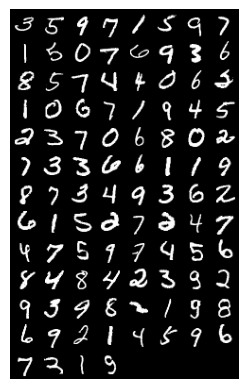

In [4]:
# Checking a sample batch and dataloader
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    plt.axis('off')
    plt.pause(0.001)  # pause a bit so that plots are updated
inputs, classes = next(iter(train_loader))

out = torchvision.utils.make_grid(inputs)

imshow(out)

### Utility Functions
- Complete the code for the function ```sample_gaussian```

In [5]:
def gaussian_parameters(h, dim=-1):
    """
    Converts generic real-valued representations into mean and variance
    parameters of a Gaussian distribution

    Args:
        h: tensor: (batch, ..., dim, ...): Arbitrary tensor
        dim: int: (): Dimension along which to split the tensor for mean and
            variance

    Returns:
        m: tensor: (batch, ..., dim / 2, ...): Mean
        v: tensor: (batch, ..., dim / 2, ...): Variance
    """
    m, h = torch.split(h, h.size(dim) // 2, dim=dim)
    v = F.softplus(h) + 1e-8
    return m, v


def sample_gaussian(m, v):
    """
    Element-wise application reparameterization trick to sample from Gaussian

    Args:
        m: tensor: (batch, ...): Mean
        v: tensor: (batch, ...): Variance

    Return:
        z: tensor: (batch, ...): Samples
    """
    ################################################################################
    # TODO: complete the code here
    # Task: Sample z
    std = torch.exp(0.5 * v)
    eps = torch.randn_like(v)
    z = m + eps * v
    # End
    ################################################################################

    return z


bce = torch.nn.BCEWithLogitsLoss(reduction='none')


def log_bernoulli_with_logits(x, logits):
    """
    Computes the log probability of a Bernoulli given its logits

    Args:
        x: tensor: (batch, dim): Observation
        logits: tensor: (batch, dim): Bernoulli logits

    Return:
        log_prob: tensor: (batch,): log probability of each sample
    """
    log_prob = -bce(input=logits, target=x).sum(-1)
    return log_prob


def kl_normal(qm, qv, pm, pv):
    """
    Computes the elem-wise KL divergence between two normal distributions KL(q || p) and
    sum over the last dimension

    Args:
        qm: tensor: (batch, dim): q mean
        qv: tensor: (batch, dim): q variance
        pm: tensor: (batch, dim): p mean
        pv: tensor: (batch, dim): p variance

    Return:
        kl: tensor: (batch,): kl between each sample
    """
    element_wise = 0.5 * (torch.log(pv) - torch.log(qv) + qv / pv + (qm - pm).pow(2) / pv - 1)
    kl = element_wise.sum(-1)
    return kl

def duplicate(x, rep):
    """
    Duplicates x along dim=0

    Args:
        x: tensor: (batch, ...): Arbitrary tensor
        rep: int: (): Number of replicates. Setting rep=1 returns orignal x

    Returns:
        _: tensor: (batch * rep, ...): Arbitrary replicated tensor
    """
    return x.expand(rep, *x.shape).reshape(-1, *x.shape[1:])

def log_normal(x, m, v):
    """
    Computes the elem-wise log probability of a Gaussian and then sum over the
    last dim. Basically we're assuming all dims are batch dims except for the
    last dim.

    Args:
        x: tensor: (batch_1, batch_2, ..., batch_k, dim): Observation
        m: tensor: (batch_1, batch_2, ..., batch_k, dim): Mean
        v: tensor: (batch_1, batch_2, ..., batch_k, dim): Variance

    Return:
        log_prob: tensor: (batch_1, batch_2, ..., batch_k): log probability of
            each sample. Note that the summation dimension is not kept
    """
    log_std = torch.log(torch.sqrt(v))
    log_probs = -((x - m) ** 2) / (2 * v) - log_std - np.log(np.sqrt(2 * np.pi))
    log_prob = log_probs.sum(-1)

    ################################################################################
    # End of code modification
    ################################################################################
    return log_prob

def log_mean_exp(x, dim):
    """
    Compute the log(mean(exp(x), dim)) in a numerically stable manner

    Args:
        x: tensor: (...): Arbitrary tensor
        dim: int: (): Dimension along which mean is computed

    Return:
        _: tensor: (...): log(mean(exp(x), dim))
    """
    return log_sum_exp(x, dim) - np.log(x.size(dim))

def log_sum_exp(x, dim=0):
    """
    Compute the log(sum(exp(x), dim)) in a numerically stable manner

    Args:
        x: tensor: (...): Arbitrary tensor
        dim: int: (): Dimension along which sum is computed

    Return:
        _: tensor: (...): log(sum(exp(x), dim))
    """
    max_x = torch.max(x, dim)[0]
    new_x = x - max_x.unsqueeze(dim).expand_as(x)
    return max_x + (new_x.exp().sum(dim)).log()

### Base Models

In [6]:
class Encoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(784 + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 2 * z_dim),
        )

    def encode(self, x, y=None):
        xy = x if y is None else torch.cat((x, y), dim=1)
        h = self.net(xy)
        m, v = gaussian_parameters(h, dim=1)
        return m, v

class Decoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(z_dim + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 784)
        )

    def decode(self, z, y=None):
        zy = z if y is None else torch.cat((z, y), dim=1)
        return self.net(zy)


### VAE Model

- Complete the functions ```negative_elbo_bound``` and ```negative_iwae_bound```. Make sure to use functions provided in the ***Utility*** and ***Base Model*** sections for your benefit when completing the code.

In [16]:
class VAE(nn.Module):
    def __init__(self, name='vae', z_dim=2):
        super().__init__()
        self.name = name
        self.z_dim = z_dim

        self.enc = Encoder(self.z_dim)
        self.dec = Decoder(self.z_dim)

        # Set prior as fixed parameter attached to Module
        self.z_prior_m = torch.nn.Parameter(torch.zeros(1), requires_grad=False)
        self.z_prior_v = torch.nn.Parameter(torch.ones(1), requires_grad=False)
        self.z_prior = (self.z_prior_m, self.z_prior_v)

    def negative_elbo_bound(self, x):
        """
        Computes the Evidence Lower Bound, KL and, Reconstruction costs

        Args:
            x: tensor: (batch, dim): Observations

        Returns:
            nelbo: tensor: (): Negative evidence lower bound
            kl: tensor: (): ELBO KL divergence to prior
            rec: tensor: (): ELBO Reconstruction term
        """
        ################################################################################
        # TODO: complete the code here
        # Task: Compute negative Evidence Lower Bound and its KL and Reconstruction term
        # Note that nelbo = kl + rec
        # Outputs should all be scalar
        # Encode input data
        z_mean, z_var = self.enc.encode(x)

        # Reparameterization trick to sample from the approximate posterior
        z_sample = sample_gaussian(z_mean, z_var)
        # Compute reconstruction
        x_recon = self.compute_sigmoid_given(z_sample)
        logits = self.dec.decode(z_sample)
        # Compute KL divergence
        kl = -0.5 * torch.sum(1 + torch.log(z_var) - z_mean.pow(2) - z_var, dim=1)
        kl = kl.mean()
        # Compute reconstruction term (negative log likelihood)
        rec = -log_bernoulli_with_logits(x, logits).mean()

        # Evidence Lower Bound (ELBO)
        nelbo = kl + rec
        # End
        ################################################################################

        return nelbo, kl, rec


    def negative_iwae_bound(self, x, iw):
        """
        Computes the Importance Weighted Autoencoder Bound
        Additionally, we also compute the ELBO KL and reconstruction terms

        Args:
            x: tensor: (batch, dim): Observations
            iw: int: (): Number of importance weighted samples

        Returns:
            niwae: tensor: (): Negative IWAE bound
            kl: tensor: (): ELBO KL divergence to prior
            rec: tensor: (): ELBO Reconstruction term
        """
        ################################################################################
        # TODO: Modify/complete the code here
        # Compute niwae (negative IWAE) with iw importance samples, and the KL
        # and Rec decomposition of the Evidence Lower Bound
        #
        # Outputs should all be scalar
        ################################################################################
        x = duplicate(x, iw)
        z_mean, z_var = self.enc.encode(x)
        z_sample = sample_gaussian(z_mean, z_var)
        x_recon = self.compute_sigmoid_given(z_sample)
        logits = self.dec.decode(z_sample)
        px_z = -log_bernoulli_with_logits(x, logits).mean()
        qz_x = log_normal(z_sample, z_mean, z_var).mean()
        pz = log_normal(z_sample, torch.zeros([int(100*iw),10]).to(device), torch.ones([int(100*iw),10]).to(device)).mean()
        niwae = px_z + pz - qz_x
        ################################################################################
        # End of code modification
        ################################################################################
        return niwae

    def loss(self, x, bound):
        if bound == "ELBO":
            nelbo, kl, rec = self.negative_elbo_bound(x)
        elif bound == "IWAE":
            nelbo, kl, rec = self.negative_iwae_bound(x,50)
        loss = nelbo

        summaries = dict((
            ('train/loss', nelbo),
            ('gen/elbo', -nelbo),
            ('gen/kl_z', kl),
            ('gen/rec', rec),
        ))

        return loss, summaries

    def sample_sigmoid(self, batch_size):
        z = self.sample_z(batch_size)
        return self.compute_sigmoid_given(z)

    def compute_sigmoid_given(self, z):
        logits = self.dec.decode(z)
        return torch.sigmoid(logits)

    def sample_z(self, batch_size):
        return sample_gaussian(
            self.z_prior[0].expand(batch_size, self.z_dim),
            self.z_prior[1].expand(batch_size, self.z_dim))

    def sample_x(self, batch_size):
        z = self.sample_z(batch_size)
        return self.sample_x_given(z)

    def sample_x_given(self, z):
        return torch.bernoulli(self.compute_sigmoid_given(z))


### Run model

- You will probably need to add some lines to this code. (Add test set, save statistics and plot, ...)

Note that Negative ELBO on the test set should be around 100.

  1%|▏         | 1/80 [00:14<19:14, 14.61s/it]

 Loss =  112.13754272460938


  2%|▎         | 2/80 [00:29<19:08, 14.72s/it]

 Loss =  108.54509735107422


  4%|▍         | 3/80 [00:45<19:52, 15.49s/it]

 Loss =  101.83943939208984


  5%|▌         | 4/80 [01:00<19:14, 15.19s/it]

 Loss =  93.60315704345703


  6%|▋         | 5/80 [01:15<19:01, 15.22s/it]

 Loss =  100.52952575683594


  8%|▊         | 6/80 [01:30<18:36, 15.09s/it]

 Loss =  96.96125030517578


  9%|▉         | 7/80 [01:45<18:18, 15.05s/it]

 Loss =  91.67203521728516


 10%|█         | 8/80 [02:00<18:02, 15.04s/it]

 Loss =  97.90943908691406


 11%|█▏        | 9/80 [02:15<17:38, 14.91s/it]

 Loss =  91.34273529052734


 12%|█▎        | 10/80 [02:29<17:18, 14.84s/it]

 Loss =  93.79054260253906


 14%|█▍        | 11/80 [02:44<17:00, 14.79s/it]

 Loss =  88.61060333251953


 15%|█▌        | 12/80 [02:59<16:43, 14.76s/it]

 Loss =  86.81492614746094


 16%|█▋        | 13/80 [03:14<16:40, 14.93s/it]

 Loss =  88.96782684326172


 18%|█▊        | 14/80 [03:29<16:22, 14.89s/it]

 Loss =  97.0301284790039


 19%|█▉        | 15/80 [03:44<16:03, 14.82s/it]

 Loss =  97.26548767089844


 20%|██        | 16/80 [03:58<15:44, 14.75s/it]

 Loss =  90.16930389404297


 21%|██▏       | 17/80 [04:13<15:22, 14.65s/it]

 Loss =  88.8026351928711


 22%|██▎       | 18/80 [04:27<15:09, 14.67s/it]

 Loss =  90.060791015625


 24%|██▍       | 19/80 [04:42<15:01, 14.79s/it]

 Loss =  89.1051025390625


 25%|██▌       | 20/80 [04:57<14:43, 14.73s/it]

 Loss =  96.89567565917969


 26%|██▋       | 21/80 [05:11<14:25, 14.67s/it]

 Loss =  92.23320770263672


 28%|██▊       | 22/80 [05:26<14:09, 14.64s/it]

 Loss =  91.82434844970703


 29%|██▉       | 23/80 [05:41<13:53, 14.62s/it]

 Loss =  89.74597930908203


 30%|███       | 24/80 [05:55<13:39, 14.63s/it]

 Loss =  90.60202026367188


 31%|███▏      | 25/80 [06:10<13:31, 14.75s/it]

 Loss =  87.3514175415039


 32%|███▎      | 26/80 [06:25<13:14, 14.71s/it]

 Loss =  91.5911865234375


 34%|███▍      | 27/80 [06:40<12:57, 14.68s/it]

 Loss =  90.89219665527344


 35%|███▌      | 28/80 [06:54<12:41, 14.64s/it]

 Loss =  87.70056915283203


 36%|███▋      | 29/80 [07:09<12:24, 14.60s/it]

 Loss =  91.31128692626953


 38%|███▊      | 30/80 [07:23<12:11, 14.63s/it]

 Loss =  88.14476013183594


 39%|███▉      | 31/80 [07:38<12:02, 14.74s/it]

 Loss =  94.98578643798828


 40%|████      | 32/80 [07:53<11:44, 14.67s/it]

 Loss =  89.926513671875


 41%|████▏     | 33/80 [08:07<11:27, 14.63s/it]

 Loss =  81.19467163085938


 42%|████▎     | 34/80 [08:22<11:13, 14.65s/it]

 Loss =  86.9245376586914


 44%|████▍     | 35/80 [08:37<10:58, 14.62s/it]

 Loss =  94.1741943359375


 45%|████▌     | 36/80 [08:52<10:47, 14.73s/it]

 Loss =  90.0614013671875


 46%|████▋     | 37/80 [09:06<10:35, 14.77s/it]

 Loss =  85.27384185791016


 48%|████▊     | 38/80 [09:21<10:18, 14.73s/it]

 Loss =  84.41548156738281


 49%|████▉     | 39/80 [09:36<10:00, 14.66s/it]

 Loss =  93.37996673583984


 50%|█████     | 40/80 [09:50<09:46, 14.66s/it]

 Loss =  87.19403076171875


 51%|█████▏    | 41/80 [10:05<09:31, 14.66s/it]

 Loss =  85.0938720703125


 52%|█████▎    | 42/80 [10:20<09:23, 14.83s/it]

 Loss =  88.66909790039062


 54%|█████▍    | 43/80 [10:35<09:08, 14.82s/it]

 Loss =  87.65460205078125


 55%|█████▌    | 44/80 [10:50<08:52, 14.78s/it]

 Loss =  89.88297271728516


 56%|█████▋    | 45/80 [11:04<08:36, 14.75s/it]

 Loss =  89.1340560913086


 57%|█████▊    | 46/80 [11:19<08:20, 14.71s/it]

 Loss =  90.70022583007812


 59%|█████▉    | 47/80 [11:37<08:43, 15.85s/it]

 Loss =  87.39749145507812


 60%|██████    | 48/80 [11:53<08:24, 15.75s/it]

 Loss =  85.79631805419922


 61%|██████▏   | 49/80 [12:08<08:05, 15.65s/it]

 Loss =  80.9961929321289


 62%|██████▎   | 50/80 [12:24<07:46, 15.55s/it]

 Loss =  84.1636734008789


 64%|██████▍   | 51/80 [12:40<07:34, 15.69s/it]

 Loss =  91.75376892089844


 65%|██████▌   | 52/80 [12:55<07:17, 15.64s/it]

 Loss =  87.16403198242188


 66%|██████▋   | 53/80 [13:11<07:01, 15.61s/it]

 Loss =  79.49638366699219


 68%|██████▊   | 54/80 [13:26<06:45, 15.60s/it]

 Loss =  86.3865966796875


 69%|██████▉   | 55/80 [13:42<06:33, 15.74s/it]

 Loss =  86.15415954589844


 70%|███████   | 56/80 [13:58<06:15, 15.63s/it]

 Loss =  88.5260238647461


 71%|███████▏  | 57/80 [14:13<05:57, 15.55s/it]

 Loss =  85.14332580566406


 72%|███████▎  | 58/80 [14:29<05:41, 15.52s/it]

 Loss =  83.21046447753906


 74%|███████▍  | 59/80 [14:45<05:29, 15.67s/it]

 Loss =  83.44825744628906


 75%|███████▌  | 60/80 [15:00<05:12, 15.61s/it]

 Loss =  81.70760345458984


 76%|███████▋  | 61/80 [15:16<04:55, 15.57s/it]

 Loss =  83.31608581542969


 78%|███████▊  | 62/80 [15:31<04:40, 15.56s/it]

 Loss =  89.73989868164062


 79%|███████▉  | 63/80 [15:47<04:26, 15.68s/it]

 Loss =  84.4572525024414


 80%|████████  | 64/80 [16:02<04:09, 15.61s/it]

 Loss =  87.11547088623047


 81%|████████▏ | 65/80 [16:18<03:53, 15.55s/it]

 Loss =  85.49310302734375


 82%|████████▎ | 66/80 [16:33<03:37, 15.51s/it]

 Loss =  89.85309600830078


 84%|████████▍ | 67/80 [16:49<03:22, 15.58s/it]

 Loss =  83.77005004882812


 85%|████████▌ | 68/80 [17:05<03:07, 15.62s/it]

 Loss =  84.04367065429688


 86%|████████▋ | 69/80 [17:20<02:51, 15.58s/it]

 Loss =  87.7000732421875


 88%|████████▊ | 70/80 [17:36<02:35, 15.53s/it]

 Loss =  84.2451400756836


 89%|████████▉ | 71/80 [17:51<02:20, 15.59s/it]

 Loss =  84.32176208496094


 90%|█████████ | 72/80 [18:07<02:04, 15.62s/it]

 Loss =  86.66264343261719


 91%|█████████▏| 73/80 [18:23<01:48, 15.57s/it]

 Loss =  91.5551986694336


 92%|█████████▎| 74/80 [18:38<01:33, 15.57s/it]

 Loss =  88.91163635253906


 94%|█████████▍| 75/80 [18:54<01:18, 15.67s/it]

 Loss =  84.53064727783203


 95%|█████████▌| 76/80 [19:10<01:02, 15.70s/it]

 Loss =  83.13765716552734


 96%|█████████▋| 77/80 [19:25<00:46, 15.63s/it]

 Loss =  86.6230697631836


 98%|█████████▊| 78/80 [19:41<00:31, 15.59s/it]

 Loss =  83.35269165039062


 99%|█████████▉| 79/80 [19:57<00:15, 15.67s/it]

 Loss =  80.8489990234375


100%|██████████| 80/80 [20:12<00:00, 15.16s/it]

 Loss =  80.39845275878906


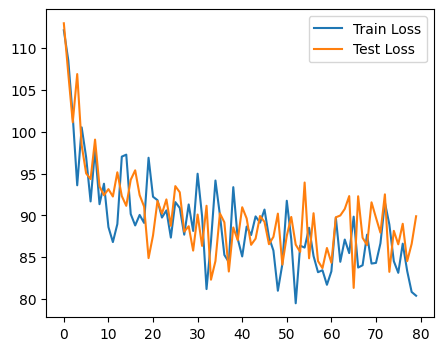

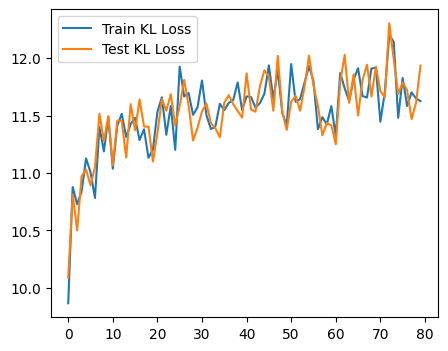

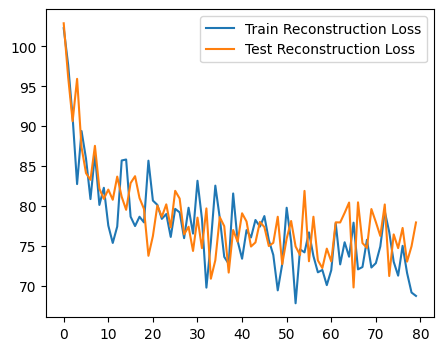

In [17]:
vae = VAE(z_dim=z).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
iter_max = 80
train_loss = np.zeros(iter_max)
train_kl = np.zeros(iter_max)
train_rec = np.zeros(iter_max)
val_loss = np.zeros(iter_max)
val_kl = np.zeros(iter_max)
val_rec = np.zeros(iter_max)
sample_batch_test, _ = next(iter(test_loader))
sample_inputs = copy.deepcopy(sample_batch_test)
for i in tqdm(range(iter_max)):
    for batch_idx, (xu, yu) in enumerate(train_loader):

        optimizer.zero_grad()

        xu = torch.bernoulli(xu.to(device).reshape(xu.size(0), -1))
        yu = yu.new(np.eye(10)[yu]).to(device).float()
        loss, summaries = vae.loss(xu, bound="ELBO")

        loss.backward()
        optimizer.step()
    ## Validation
    for batch_idx, (xu, yu) in enumerate(test_loader):
        optimizer.zero_grad()
        xu = torch.bernoulli(xu.to(device).reshape(xu.size(0), -1))
        yu = yu.new(np.eye(10)[yu]).to(device).float()
        _, summaries_val = vae.loss(xu, bound="ELBO")
    train_loss[i] = summaries['train/loss'].cpu().detach().numpy()
    train_kl[i] = summaries['gen/kl_z'].cpu().detach().numpy()
    train_rec[i] = summaries['gen/rec'].cpu().detach().numpy()
    val_loss[i] = summaries_val['train/loss'].cpu().detach().numpy()
    val_kl[i] = summaries_val['gen/kl_z'].cpu().detach().numpy()
    val_rec[i] = summaries_val['gen/rec'].cpu().detach().numpy()
    print(" Loss = ", train_loss[i])
    if (i+1)% 10 == 0:
        xu = torch.bernoulli(sample_inputs.to(device).reshape(sample_inputs.size(0), -1))
        z_mean, z_log_var = vae.enc.encode(xu)
        z_sample = sample_gaussian(z_mean, z_log_var)
        x_recon = vae.compute_sigmoid_given(z_sample)
        out = x_recon.cpu().reshape([100,1,28,28])
        sample_batch_test = torch.cat((sample_batch_test, out), dim=0)
    ################################################################################
    # TODO: complete the code here
    # report the loss terms across time for train and validation datasets
    #
    # You can choose to only perform validation once in every 10 (Or any other number
    # depending on the speed of the algorithm on your machine) iterations and display
    # the training and validation statistics on those iterataions.
plt.figure(figsize=(5,4))
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['Train Loss', 'Test Loss'])
plt.show()
plt.figure(figsize=(5,4))
plt.plot(train_kl)
plt.plot(val_kl)
plt.legend(['Train KL Loss', 'Test KL Loss'])
plt.show()
plt.figure(figsize=(5,4))
plt.plot(train_rec)
plt.plot(val_rec)
plt.legend(['Train Reconstruction Loss', 'Test Reconstruction Loss'])
plt.show()

    # End
    ################################################################################

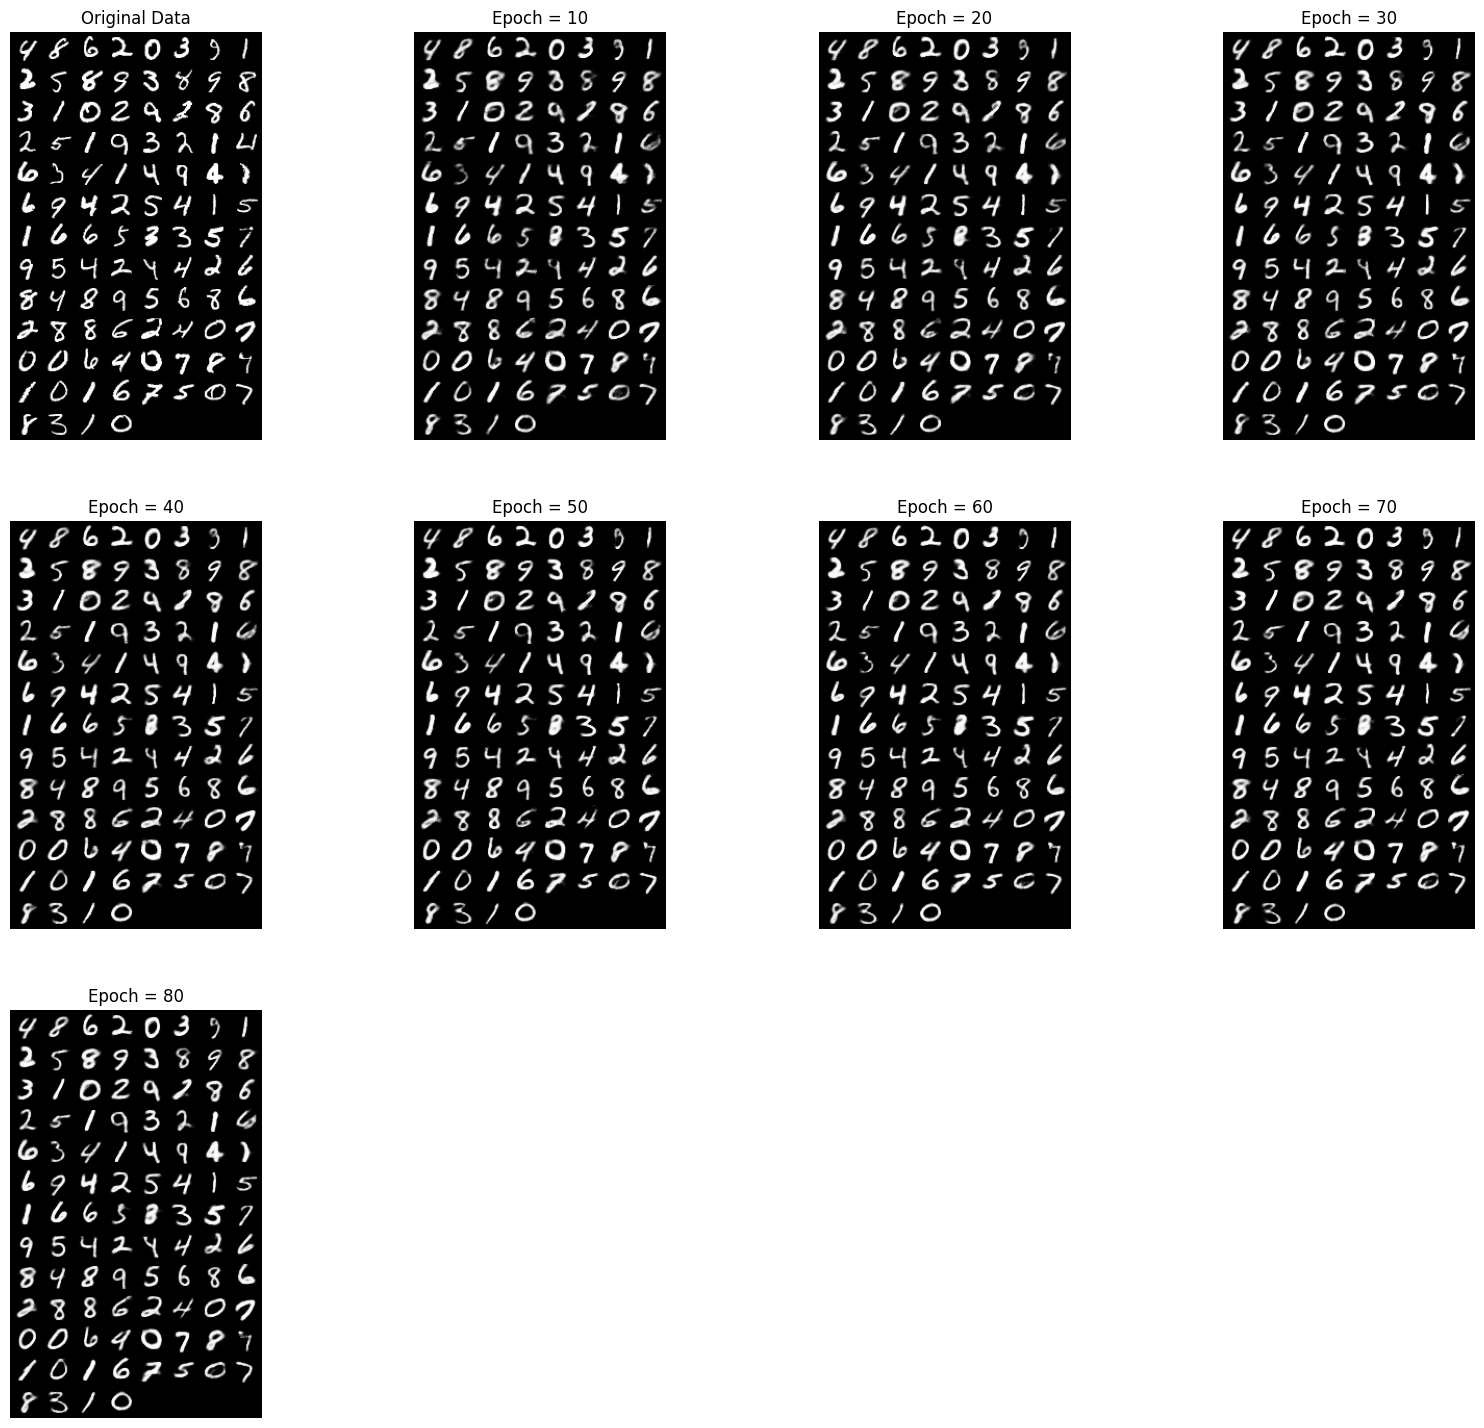

In [21]:
plt.figure(figsize=(20,18))
plt.subplot(3,4,1, frameon=False)
out = torchvision.utils.make_grid(sample_batch_test[0:100])
out = out.numpy().transpose((1, 2, 0))
plt.imshow(out)
plt.title('Original Data')
plt.axis('off')
for i in range(int(iter_max/10)):
    plt.subplot(3,4,i+2, frameon=False)
    out = torchvision.utils.make_grid(sample_batch_test[0+100*(i+1):100*(i+1)+100])
    out = out.numpy().transpose((1, 2, 0))
    plt.imshow(out)
    plt.title('Epoch = {epoch}'.format(epoch=int(10*(i+1))))
    plt.axis('off')
plt.show()

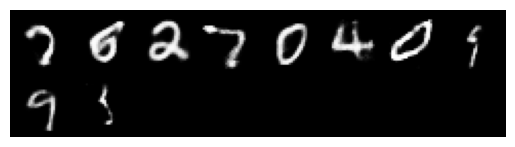

In [24]:
with torch.no_grad():
    z_samples = torch.randn(10, 10).to(device)  # Sample from a standard normal distribution
    x_recon = vae.compute_sigmoid_given(z_samples)
    out = x_recon.cpu().reshape([10,1,28,28])
out = torchvision.utils.make_grid(out)

imshow(out)

In [20]:
with torch.no_grad():
    for batch_idx, (xu, yu) in enumerate(test_loader):
        optimizer.zero_grad()
        xu = torch.bernoulli(xu.to(device).reshape(xu.size(0), -1))
        nelbo, summaries_val = vae.loss(xu, bound="ELBO")
        niwae5 = vae.negative_iwae_bound(xu, 5)
        niwae50 = vae.negative_iwae_bound(xu, 50)
        niwae150 = vae.negative_iwae_bound(xu, 150)
print('NELBO = ', nelbo, 'NIWAE_5 = ', niwae5, 'NIWAE_50 = ', niwae50, 'NIWAE_150 = ', niwae150)

NELBO =  tensor(85.0137) NIWAE_5 =  tensor(56.7905) NIWAE_50 =  tensor(56.7616) NIWAE_150 =  tensor(56.7603)
